**Project 3 -- Kidney Detection in dw-MRI Volumes -- UNET Implementation**

**Import the Required Libraries**

In [1]:
# Import required libraries
from monai.utils import first, set_determinism
from monai.transforms import (
AsDiscrete,
AsDiscreted,
EnsureChannelFirstd,
Compose,
CropForegroundd,
LoadImaged,
Orientationd,
Spacingd,
Invertd,
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
from monai.losses import DiceLoss
from monai.metrics import DiceMetric

import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob

from sklearn.model_selection import train_test_split
from skimage.measure import label, regionprops

import SimpleITK as sitk


**Import and Prepare the Dataset**

This includes importation of the images and masks, combining the left and right kidney masks into a single mask, completing a train/test split, and visualizing the dataset.

In [2]:
# Define paths to the folders containing images and masks
data_folder = "/projectnb/ec500kb/projects/Project_3/Maolin/Data/"
masks_folder = "/projectnb/ec500kb/projects/Project_3/Maolin/Data/"  # Same as the image folder

# Create empty lists to store image and mask data
image_dataset = []
left_mask_dataset = []
right_mask_dataset = []

# Iterate through image files and import them
for images_folder in os.listdir(data_folder):
    if os.path.isdir(os.path.join(data_folder, images_folder)):
        print(images_folder)
        for filename in os.listdir(os.path.join(data_folder, images_folder)):
            if filename.endswith('.nrrd'):
                # Construct full path to the image file
                raw_img_path = os.path.join(data_folder, images_folder, filename)

                # Read in image
                raw_img_sitk = sitk.ReadImage(raw_img_path, sitk.sitkFloat32)

                # Convert the array
                raw_img_sitk_arr = sitk.GetArrayFromImage(raw_img_sitk)

                # Add image data to list
                image_dataset.append(raw_img_sitk_arr)

                # Iterate through each mask file
                for side in ["left", "right"]:  # It is done this way so that I import 5 copies of each mask. since the same mask is used for each image volume
                    mask_filename = f"svr_{side}KidneyMask2.nii.gz"
                    mask_path = os.path.join(masks_folder, images_folder, mask_filename)

                    # Read in mask
                    raw_mask_sitk = sitk.ReadImage(mask_path, sitk.sitkFloat32)

                    # Convert the array
                    mask_arr = sitk.GetArrayFromImage(raw_mask_sitk)

                    if side == "left":
                        left_mask_dataset.append(mask_arr[0])
                    elif side == "right":
                        right_mask_dataset.append(mask_arr[0])

# Convert lists to numpy arrays
image_dataset = np.array(image_dataset)
left_mask_dataset = np.array(left_mask_dataset)
right_mask_dataset = np.array(right_mask_dataset)

# Print the shapes to verify
print("Image dataset shape:", image_dataset.shape)  # samples, slices, slice_x, slice_y
print("Left Mask dataset shape:", left_mask_dataset.shape)
print("Right Mask dataset shape:", right_mask_dataset.shape)



case7
case3
case4
case5
case8
case1
case2
case6
Image dataset shape: (40, 18, 128, 128)
Left Mask dataset shape: (40, 128, 128)
Right Mask dataset shape: (40, 128, 128)


In [3]:
# Combine the left and right kidney masks into one mask
combined_masks = []

for i in range(len(left_mask_dataset)):
    combined_masks.append(left_mask_dataset[i] + right_mask_dataset[i])
    

# Split the data into training and testing sets
#X_train, X_test, y_train, y_test = train_test_split(image_dataset, combined_masks, test_size=0.2, random_state=42)

In [4]:
np.shape(image_dataset)

(40, 18, 128, 128)

In [5]:
X_train = image_dataset[1:31]
X_test = image_dataset[31:]

y_train = combined_masks[1:31]
y_test = combined_masks[31:]

In [6]:
np.shape(image_dataset[0])
print(len(combined_masks))

40


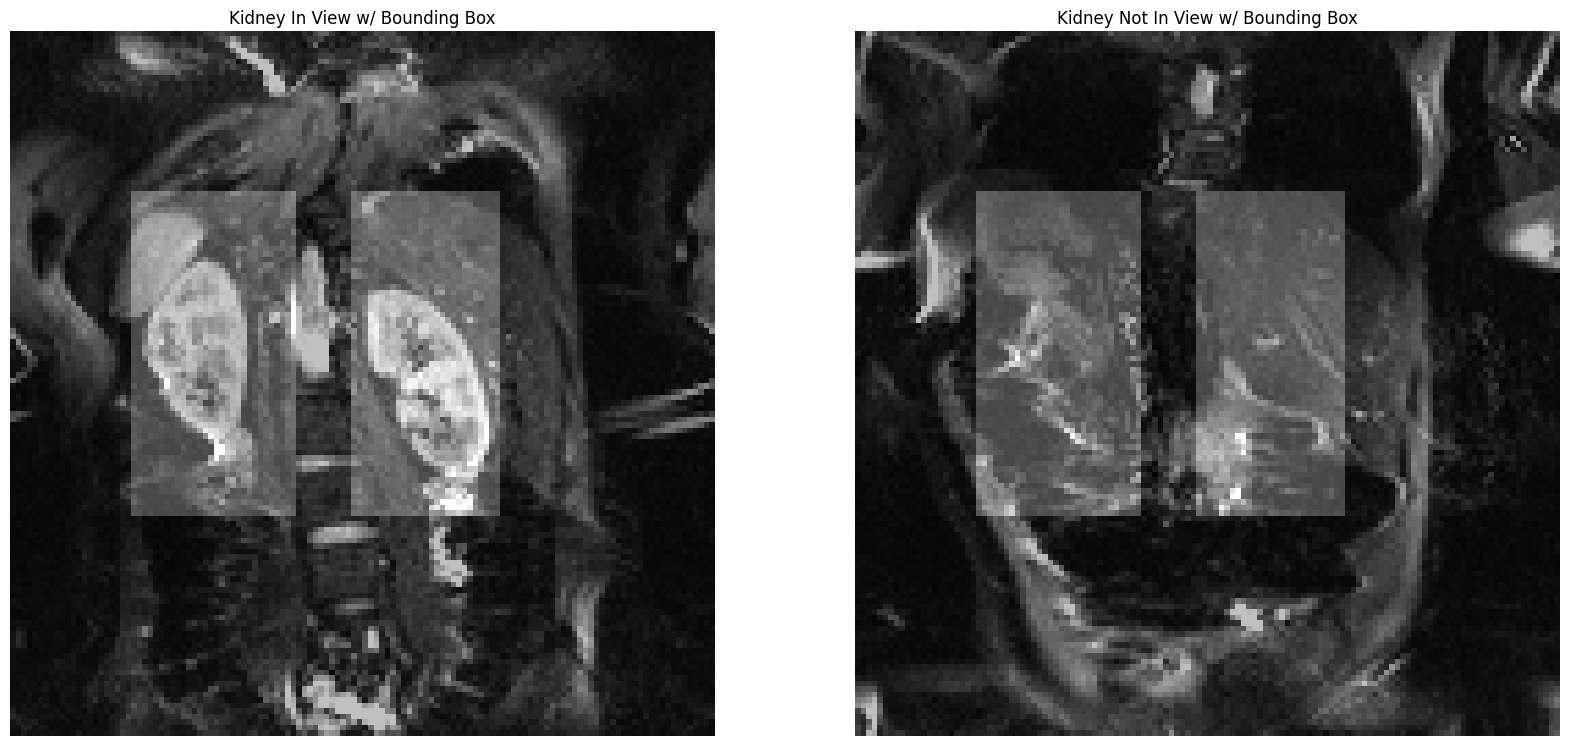

In [32]:
import matplotlib.pyplot as plt
import numpy as np

img_number = 1
slice = 11
slice2 = 1

# Brightness adjustment parameters
brightness_factor = 0.5  # Adjust as needed
brightness_offset = 0 # Adjust as needed

# Brighten images
brightened_image = brightness_factor * image_dataset[img_number][slice] + brightness_offset
brightened_image2 = brightness_factor * image_dataset[img_number][slice2] + brightness_offset

# Rotate images 90 degrees
rotated_image = np.rot90(brightened_image)
rotated_image2 = np.rot90(brightened_image2)

# Rotate masks
rotated_mask = np.rot90(combined_masks[img_number])

plt.figure(figsize=(20, 20))
plt.subplot(1, 2, 1)
plt.imshow(rotated_image, cmap='gray', vmin=0, vmax=255)  # Adjust vmin and vmax for the desired intensity range
plt.imshow(rotated_mask, cmap='gray', alpha=0.25)
plt.title("Kidney In View w/ Bounding Box")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(rotated_image2, cmap='gray', vmin=0, vmax=255)
plt.imshow(rotated_mask, cmap='gray', alpha=0.25)
plt.title("Kidney Not In View w/ Bounding Box")
plt.axis("off")

plt.savefig("Dataset_Description.png")


**Define and Train the UNET**

In [33]:


# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Define the UNet model
class MyUNet(nn.Module):
    def __init__(self):
        super(MyUNet, self).__init__()
        self.unet = UNet(
            spatial_dims=2,  # Set spatial dimensions to 2 for 2D data
            in_channels=18,  # Input volume with 18 channels
            out_channels=1,  # Single channel output mask
            channels=(16, 32, 64, 128, 256), #, 256 # Depth of 5
            strides=(2, 2, 2, 2),
            num_res_units=2,  # Number of residual units
            dropout=0.1
        )

    def forward(self, x):
        return self.unet(x)

# Initialize the model and move it to the GPU
model = MyUNet().to(device)

# Define Dice Loss
criterion = DiceLoss(sigmoid=True)

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Convert numpy arrays to PyTorch tensors and move them to GPU
# Assuming X_train is of shape (6, 128, 128, 18)
X_train_tensor = torch.FloatTensor(X_train).permute(0, 1,2,3).to(device)  # Permute to have correct dimension order
y_train_tensor = torch.FloatTensor(y_train).unsqueeze(1).to(device)

print(y_train_tensor.shape)
big_loss = []
print(X_train_tensor.shape)
# Train the model
num_epochs = 1000
for epoch in range(num_epochs):
    # Set the model to train mode
    model.train()
    
    # Forward pass
    outputs = model(X_train_tensor)
    
    # Compute the loss
    loss = criterion(outputs, y_train_tensor)
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    big_loss.append(loss.item())
    # Print loss every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')



Using device: cuda
torch.Size([30, 1, 128, 128])
torch.Size([30, 18, 128, 128])
Epoch [10/1000], Loss: 0.6401
Epoch [20/1000], Loss: 0.6263
Epoch [30/1000], Loss: 0.6164
Epoch [40/1000], Loss: 0.6084
Epoch [50/1000], Loss: 0.5998
Epoch [60/1000], Loss: 0.5906
Epoch [70/1000], Loss: 0.5802
Epoch [80/1000], Loss: 0.5663
Epoch [90/1000], Loss: 0.5466
Epoch [100/1000], Loss: 0.5144
Epoch [110/1000], Loss: 0.4812
Epoch [120/1000], Loss: 0.4429
Epoch [130/1000], Loss: 0.4068
Epoch [140/1000], Loss: 0.3767
Epoch [150/1000], Loss: 0.3543
Epoch [160/1000], Loss: 0.3328
Epoch [170/1000], Loss: 0.3165
Epoch [180/1000], Loss: 0.3009
Epoch [190/1000], Loss: 0.2861
Epoch [200/1000], Loss: 0.2724
Epoch [210/1000], Loss: 0.2593
Epoch [220/1000], Loss: 0.2469
Epoch [230/1000], Loss: 0.2353
Epoch [240/1000], Loss: 0.2233
Epoch [250/1000], Loss: 0.2137
Epoch [260/1000], Loss: 0.2088
Epoch [270/1000], Loss: 0.1933
Epoch [280/1000], Loss: 0.1826
Epoch [290/1000], Loss: 0.1732
Epoch [300/1000], Loss: 0.1645

In [34]:
# Evaluate the model on the test set if needed
X_test_tensor = torch.FloatTensor(X_test).permute(0, 1,2,3).to(device)  # Permute to have correct dimension order
y_test_tensor = torch.FloatTensor(y_test).unsqueeze(1).to(device)

test_masks = []

model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor)
    test_loss = criterion(outputs, y_test_tensor)
    print(f'Test Loss: {test_loss.item():.4f}')
    test_masks = [thing.cpu() for thing in outputs]


Test Loss: 0.1087


In [100]:
thresholded_masks = []

for mask in test_masks:
    # Calculate intensity range
    min_intensity = torch.min(mask)
    max_intensity = torch.max(mask)
    intensity_range = max_intensity - min_intensity
    
    # Calculate 50% mark
    threshold = min_intensity + 0.5 * intensity_range
    
    # Threshold the mask
    thresholded_mask = torch.where(mask >= threshold, torch.tensor(1), torch.tensor(0))
    
    # Append the thresholded mask to the list
    thresholded_masks.append(thresholded_mask)
    
thresholded_masks_train = []

for mask in y_train:
    # Calculate intensity range
    min_intensity = np.min(mask)
    max_intensity = np.max(mask)
    intensity_range = max_intensity - min_intensity
    
    # Calculate 50% mark
    threshold = min_intensity + 0.5 * intensity_range
    
    # Threshold the mask
    thresholded_mask = np.where(mask >= threshold, 1, 0)
    
    # Append the thresholded mask to the list
    thresholded_masks_train.append(thresholded_mask)

In [36]:
dice_metric = DiceMetric(include_background=True)

# Calculate Dice score
test_dice = []

for idx in range(len(test_masks)):
    # Get proper shapes for dice score function
    y_true = torch.tensor(y_test[idx]).unsqueeze(0).unsqueeze(0)
    y_pred = torch.tensor(thresholded_masks[idx]).unsqueeze(0).unsqueeze(0)
    
    # Calculate the dice score :P
    dice = dice_metric(y_pred, y_true)
    
    # append to the list of dice
    test_dice.append(float(dice))

print(test_dice)

[0.9965870380401611, 0.9939163327217102, 0.9956983923912048, 0.9919999837875366, 0.7835025191307068, 0.8400202989578247, 0.7870381474494934, 0.8300628662109375, 0.8158561587333679]


/scratch/6910129.1.ece/ipykernel_1589385/1825874595.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred = torch.tensor(thresholded_masks[idx]).unsqueeze(0).unsqueeze(0)


tensor(-8.1511)
tensor(-8.1192)


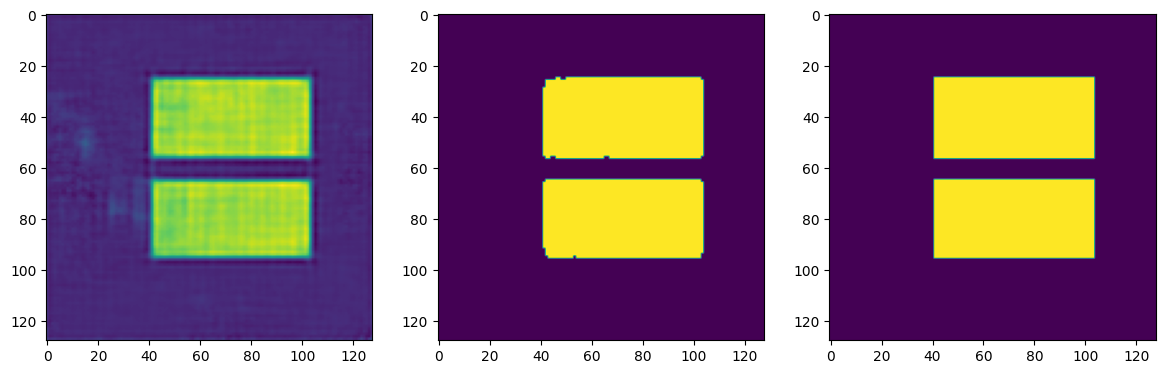

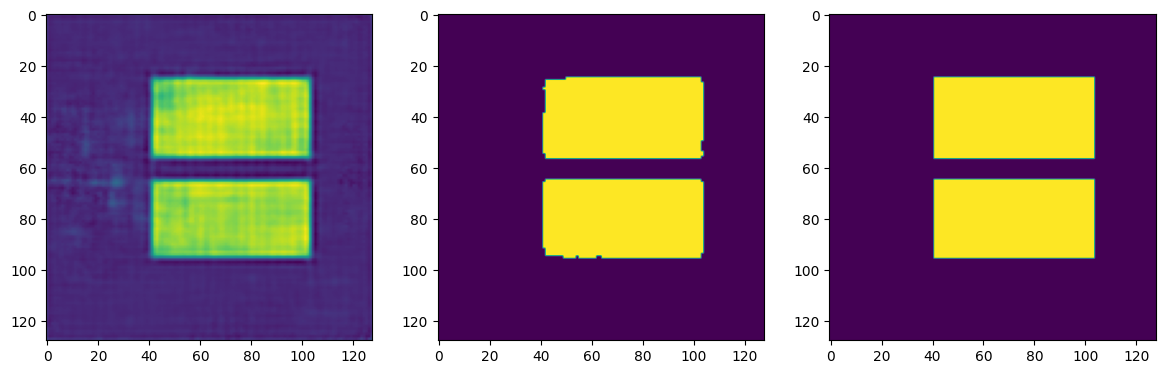

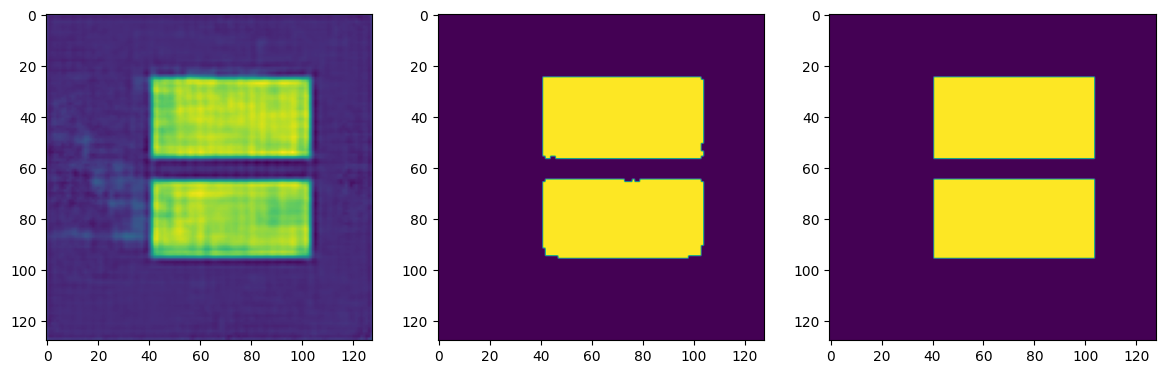

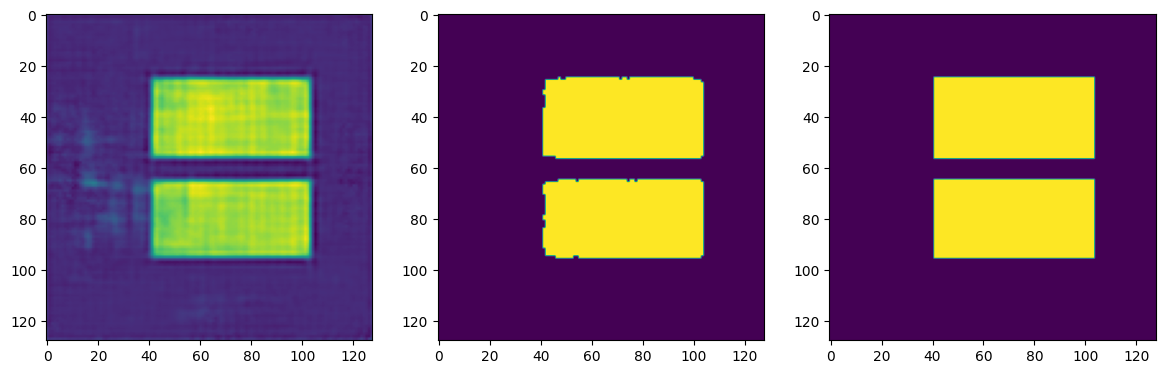

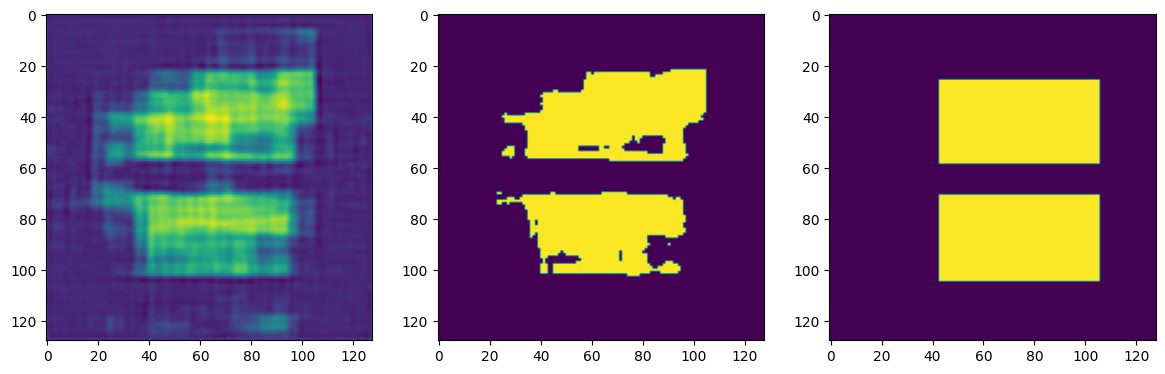

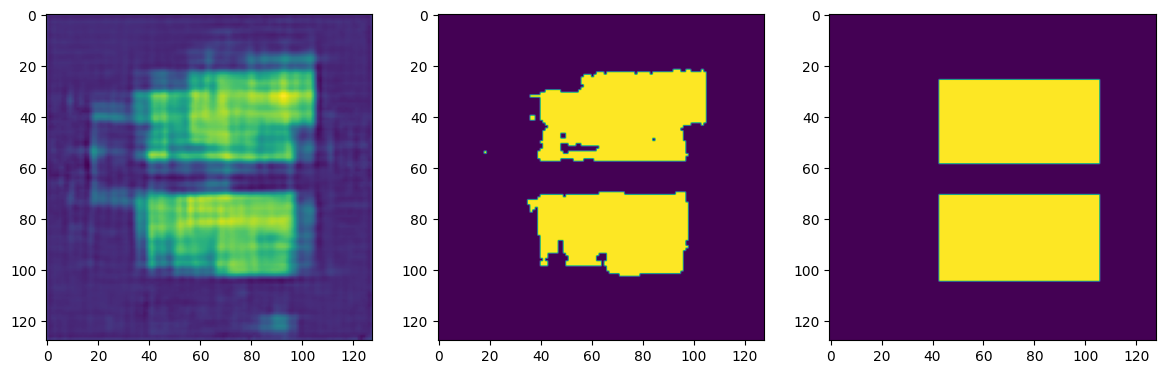

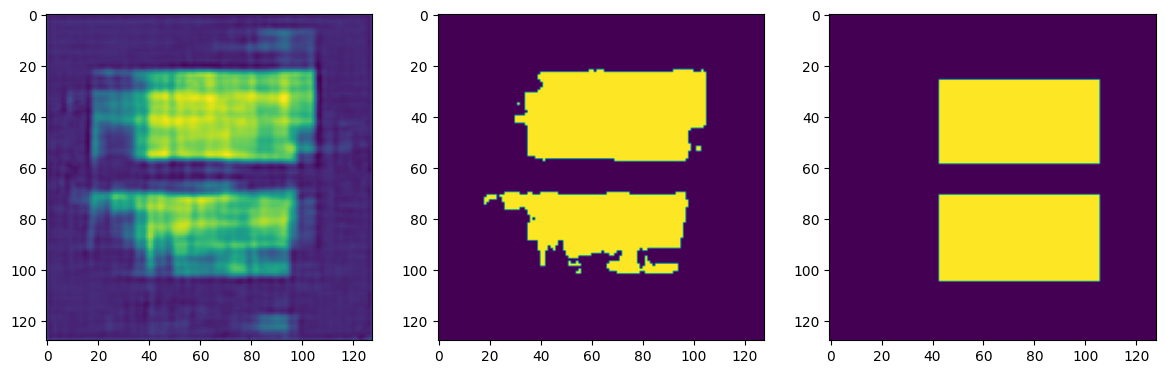

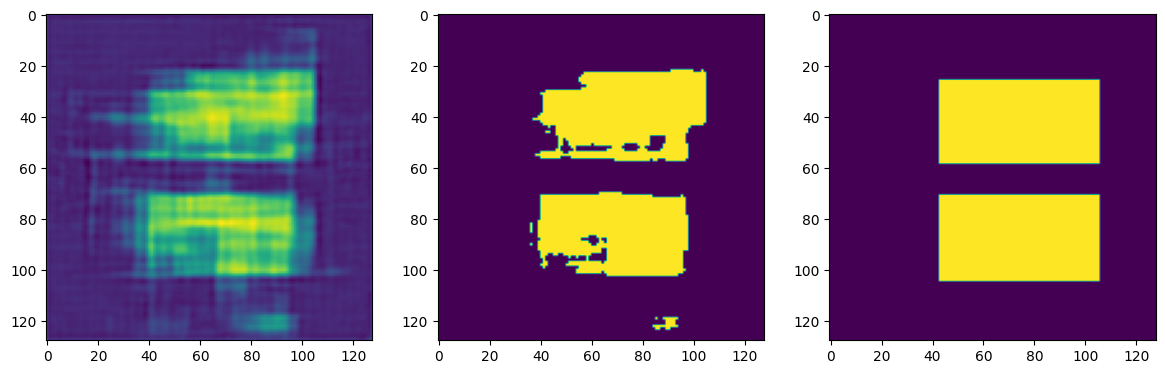

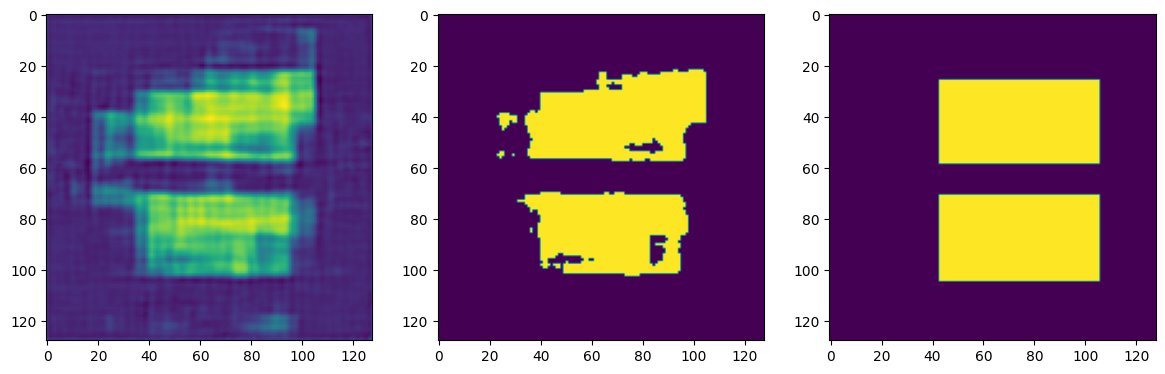

In [37]:
print(torch.min(test_masks[0]))
print(torch.min(test_masks[1]))

for idx in range(len(test_masks)):
    plt.figure(figsize=(80, 80))
    plt.subplot(3, 16, idx+1)
    plt.imshow(test_masks[idx].numpy()[0])
    
    plt.subplot(3, 16, idx+2)
    plt.imshow(thresholded_masks[idx][0])

    plt.subplot(3, 16, idx+3)
    plt.imshow(y_test[idx])
plt.show()

In [106]:


def bounding_box_edges(mask):
    labeled_mask = label(mask)
    
    bboxes = []
    if labeled_mask.max() == 0:
        return mask
    
    border = np.zeros_like(mask)
    
    for region in regionprops(labeled_mask):
        min_row, min_col, max_row, max_col = region.bbox
        # Fill in bounding box edges
        border[min_row:min_row+2, min_col:max_col+1] = 1  # top edge
        border[max_row-1:max_row+1, min_col:max_col+1] = 1  # bottom edge
        border[min_row:max_row+1, min_col:min_col+2] = 1  # left edge
        border[min_row:max_row+1, max_col-1:max_col+1] = 1  # right edge
    
    return border

def calculate_iou(bbox1, bbox2):
    # Calculate intersection
    intersection = np.logical_and(bbox1, bbox2)

    # Calculate union
    union = np.logical_or(bbox1, bbox2)

    # Calculate IoU
    iou = np.sum(intersection) / np.sum(union)

    return iou


# Create bounding box coordinates
mask_array = []
bboxes = []
for i in range(len(y_test)):
    mask_array.append(thresholded_masks[i][0].numpy())
    bboxes.append(bounding_box_edges(mask_array[i]))

    
    # Create bounding box coordinates
mask_array_train = []
bboxes_train = []
for i in range(len(y_test)):
    mask_array_train.append(thresholded_masks_train[i])
    bboxes_train.append(bounding_box_edges(mask_array[i]))


In [107]:
IOU_storage = []
for i in range(len(mask_array)):
    IOU_storage.append(calculate_iou(mask_array[i], y_test[i]))
    #print(calculate_iou(mask_array[i], y_test[i]))
    
IOU_storage_train = []
for i in range(len(mask_array_train)):
    IOU_storage_train.append(calculate_iou(mask_array_train[i], y_train[i]))

In [111]:
IOU_storage

[0.9931972789115646,
 0.9879062736205594,
 0.9914336104812296,
 0.9841269841269841,
 0.6440642603797204,
 0.7241681260945709,
 0.6488565067800041,
 0.7094935321201491,
 0.6889839572192513]

In [108]:
IOU_storage_train

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

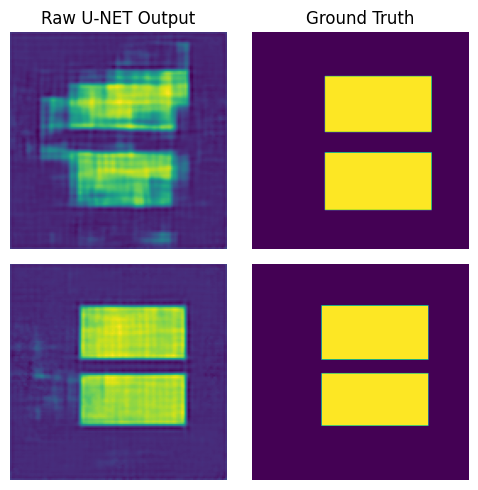

In [187]:
idx = 8

plt.figure(figsize=(5, 5))

# First set of subplots
plt.subplot(2, 2, 1)
plt.imshow(test_masks[8].numpy()[0])
plt.ylabel("Example Pair 1")
plt.title("Raw U-NET Output")
plt.axis("off")

plt.subplot(2, 2, 2)
plt.imshow(y_test[8])
plt.title("Ground Truth")
plt.axis("off")

# Second set of subplots
plt.subplot(2, 2, 3)
plt.imshow(test_masks[3].numpy()[0])
plt.ylabel("Example Pair 2")
plt.axis("off")

plt.subplot(2, 2, 4)
plt.imshow(y_test[3])
plt.axis("off")

plt.tight_layout()  # Adjust subplots to prevent overlap
plt.show()


Text(0, 0.5, 'Loss')

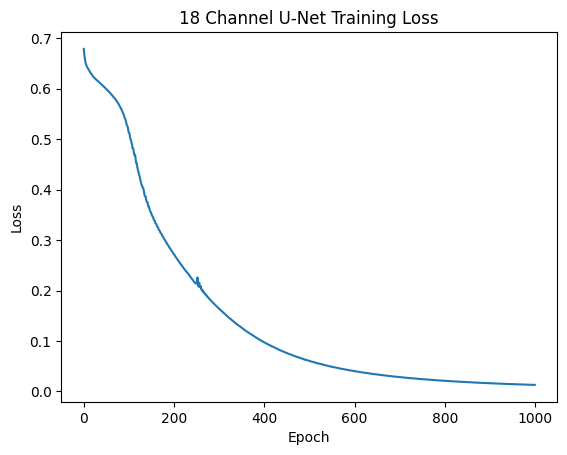

In [45]:
plt.plot(big_loss)
plt.title("18 Channel U-Net Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

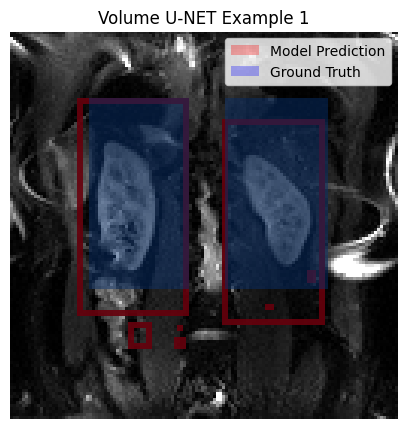

In [158]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch

img_number = 39
box = 8
slice = 11

img = image_dataset[img_number][slice]
img = np.rot90(img)

lower_bound, upper_bound = np.percentile(img, 0.5), np.percentile(img, 99.5)
img = np.clip(img, lower_bound, upper_bound)
img = (img - lower_bound) / (upper_bound - lower_bound) * 255

plt.figure(figsize=(5, 10))
plt.imshow(img, cmap="gray")

# Plot masks with specified labels
rotated_mask = np.rot90(bboxes[box])
rotated_mask2 = np.rot90(combined_masks[img_number])

# Create masks with zeros where there are no actual mask values
masked_rotated_mask = np.where(rotated_mask == 0, np.nan, 1)  # Using 1 instead of np.nan
masked_rotated_mask2 = np.where(rotated_mask2 == 0, np.nan, 1)  # Using 1 instead of np.nan

# Plot the masks with their respective colors
plt.imshow(masked_rotated_mask, cmap='Reds', alpha=0.9, label='Model Prediction', vmin=0, vmax=1)
plt.imshow(masked_rotated_mask2, cmap='Blues', alpha=0.5, label='Ground Truth', vmin=0, vmax=1)

plt.title("Volume U-NET Example 1")
plt.axis("off")

# Define legend handles
legend_handles = [Patch(facecolor='red', alpha=0.3), Patch(facecolor='blue', alpha=0.3)]

# Plot legend
plt.legend(legend_handles, ['Model Prediction', 'Ground Truth'])

plt.show()
